# **Micro** **Dataset** **Training**

### Due to the absence of labels in the test set, we adopted an alternative strategy for evaluating our Convolutional Neural Network (CNN) and the VGG-based transfer learning model.



### We utilized a subset of 12k labeled images from the training set and split it further, creating a new micro dataset. This micro dataset was stratified to maintain a uniform class distribution, aligning with the overall dataset composition.

#### The split was as follows: Micro Training Set: 70%, Micro Validation Set: 15% Micro Test Set: The remaining 15% were used to test the models' performance.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/My  Drive/Human Action Recognition'

In [4]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Paths to your data and CSV files
dataset_path = '/content/drive/My Drive/HAR/Human Action Recognition'
train_path = os.path.join(dataset_path, 'train')
train_labels_path = os.path.join(dataset_path, 'Training_set.csv')

# Load the labels from the CSV file into a DataFrame
train_labels_df = pd.read_csv(train_labels_path)

# Check that you have more than one instance per class
print(train_labels_df['label'].value_counts())

# Split the data into train and temp (which will be split into validation and test)
train_df, temp_df = train_test_split(train_labels_df, test_size=0.3, random_state=42, stratify=train_labels_df['label'])

# Split the temp data into validation and test sets
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Verify the distribution of the splits
print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(valid_df)} samples")
print(f"Test set: {len(test_df)} samples")

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64
Train set: 8820 samples
Validation set: 1890 samples
Test set: 1890 samples


In [5]:
# To check if the classes are indeed balanced across the splits, we will calculate the distribution of each class
# in the train, validation, and test sets and compare them.

# Let's create a function to display the class distribution
def display_class_distribution(df, set_name):
    distribution = df['label'].value_counts(normalize=True).sort_index()
    print(f"Class distribution in {set_name} set:")
    print(distribution)
    print("\n")

# Now we will display the class distribution for each set
display_class_distribution(train_df, 'train')
display_class_distribution(valid_df, 'validation')
display_class_distribution(test_df, 'test')

# Additionally, we want to check if the number of samples for each class is roughly the same in each set
# We will calculate the standard deviation of the sample counts to see how they vary
train_std = train_df['label'].value_counts().std()
valid_std = valid_df['label'].value_counts().std()
test_std = test_df['label'].value_counts().std()

train_std, valid_std, test_std

Class distribution in train set:
calling               0.066667
clapping              0.066667
cycling               0.066667
dancing               0.066667
drinking              0.066667
eating                0.066667
fighting              0.066667
hugging               0.066667
laughing              0.066667
listening_to_music    0.066667
running               0.066667
sitting               0.066667
sleeping              0.066667
texting               0.066667
using_laptop          0.066667
Name: label, dtype: float64


Class distribution in validation set:
calling               0.066667
clapping              0.066667
cycling               0.066667
dancing               0.066667
drinking              0.066667
eating                0.066667
fighting              0.066667
hugging               0.066667
laughing              0.066667
listening_to_music    0.066667
running               0.066667
sitting               0.066667
sleeping              0.066667
texting               0.066667


(0.0, 0.0, 0.0)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming dataset_path, train_path, and train_labels_path are defined as before
# Define ImageDataGenerators with normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators for training, validation, and test data using the dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='filename',
    y_col='label',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_path,  # Assuming validation images are in the same directory as training
    x_col='filename',
    y_col='label',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

# Generator for test data using the dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # Using the test_df from the split above
    directory=train_path,  # Assuming test images are in the same directory as training
    x_col='filename',
    target_size=(32, 32),
    batch_size=32,
    class_mode=None,  # Since we don't have labels in the generator
    shuffle=False  # Keep data in same order as dataframe for evaluation
)

Found 8820 validated image filenames belonging to 15 classes.
Found 1890 validated image filenames belonging to 15 classes.
Found 1890 validated image filenames.


In [ ]:
import tensorflow as tf

# Number of unique classes in your dataset
num_unique_classes = 15  # Assuming 15 different classes

# Instantiate a Sequential model
cnn = tf.keras.models.Sequential()

# Add a Convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[32, 32, 3]))

# Add a Pooling layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Add a second Convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

# Add a second Pooling layer
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Add a Flattening layer
cnn.add(tf.keras.layers.Flatten())

# Add a Fully-connected layer
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Add an Output layer
cnn.add(tf.keras.layers.Dense(units=num_unique_classes, activation='softmax'))

# Print the model summary
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [ ]:
# Compile the model with Adam optimizer and categorical crossentropy loss
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25  # Adjust the number of epochs as needed
)

Epoch 1/25
275/275 [==============================] - 299s 1s/step - loss: 2.6451 - accuracy: 0.1103 - val_loss: 2.6090 - val_accuracy: 0.1488
Epoch 2/25
275/275 [==============================] - 31s 114ms/step - loss: 2.5089 - accuracy: 0.1726 - val_loss: 2.4876 - val_accuracy: 0.2060
Epoch 3/25
275/275 [==============================] - 30s 110ms/step - loss: 2.4204 - accuracy: 0.1982 - val_loss: 2.6368 - val_accuracy: 0.1912
Epoch 4/25
275/275 [==============================] - 31s 113ms/step - loss: 2.3518 - accuracy: 0.2210 - val_loss: 2.5365 - val_accuracy: 0.1981
Epoch 5/25
275/275 [==============================] - 31s 113ms/step - loss: 2.3185 - accuracy: 0.2416 - val_loss: 2.3109 - val_accuracy: 0.2415
Epoch 6/25
275/275 [==============================] - 31s 112ms/step - loss: 2.2889 - accuracy: 0.2429 - val_loss: 2.3924 - val_accuracy: 0.2410
Epoch 7/25
275/275 [==============================] - 31s 113ms/step - loss: 2.2505 - accuracy: 0.2613 - val_loss: 2.6141 - val_accu

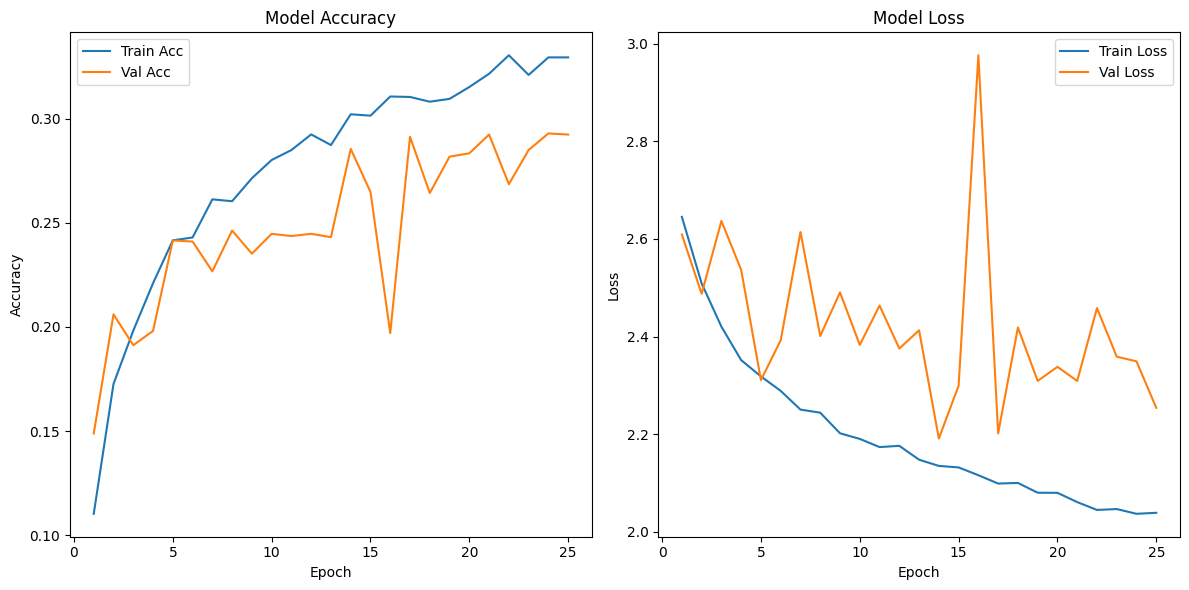

In [ ]:
import matplotlib.pyplot as plt

# Replace the values in `accuracy`, `val_accuracy`, `loss`, and `val_loss` with your actual history data.
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Train Acc')
plt.plot(epochs, val_accuracy, label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

CNN model gave low accuracy so we try the vgg model also

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

checkpoint_path = "/content/drive/My Drive/vgg_model_weights.h5"  # Path in your Google Drive

Mounted at /content/drive


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

vgg_model = Sequential()

# Load the pre-trained VGG16 model without the top classification layer
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(32, 32, 3),
    pooling='avg',  # Applies global average pooling to the output of the last conv layer
    weights='imagenet'
)

# Freeze the layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model as the base
vgg_model.add(pretrained_model)

# Add new classification layers
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
vgg_model.add(Dense(15, activation='softmax'))  # 15 classes for your dataset

# Print the model summary
vgg_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14985039 (57.16 MB)
Trainable params: 270351 (1.03 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

vgg_model = Sequential()

# Load the pre-trained VGG16 model without the top classification layer
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(32, 32, 3),
    pooling='avg',  # Applies global average pooling to the output of the last conv layer
    weights='imagenet'
)

# Freeze the layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model as the base
vgg_model.add(pretrained_model)

# Add new classification layers
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
vgg_model.add(Dense(15, activation='softmax'))  # 15 classes for your dataset

# Print the model summary
vgg_model.summary()

# Define the checkpoint callback
checkpoint_path = "vgg_model_weights.h5"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    save_freq='epoch'
)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

# Compile the model
vgg_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Fit the model with the checkpoint and early stopping callbacks
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=[checkpoint_callback, early_stopping_callback]  # Add the early stopping callback here
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14985039 (57.16 MB)
Trainable params: 270351 (1.03 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
275/275 [==============================] - ETA: 0s - loss: 2.5352 - accuracy: 0.1656
Epoch 1: val_loss improved from inf to 2.3086

So with early stopping we got the best accuracy of 30%

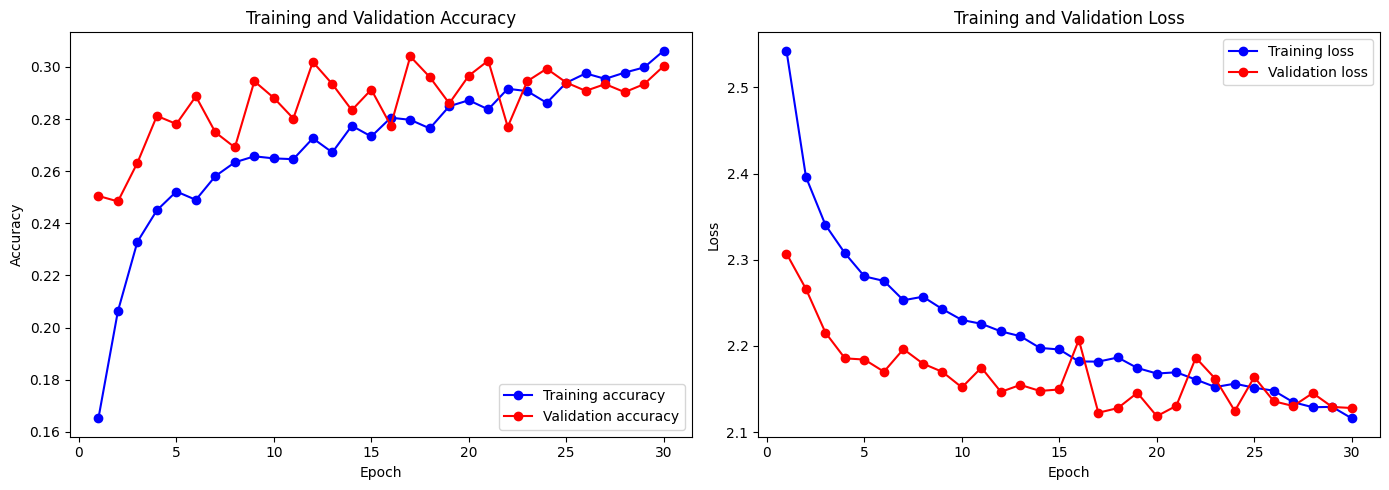

In [ ]:
import matplotlib.pyplot as plt

# Manually extracted values from the provided training output
accuracy = [0.1652, 0.2063, 0.2329, 0.2450, 0.2522, 0.2490, 0.2581, 0.2634, 0.2657, 0.2649, 0.2646, 0.2726, 0.2672, 0.2774, 0.2733, 0.2805, 0.2797, 0.2764, 0.2849, 0.2872, 0.2837, 0.2916, 0.2907, 0.2862, 0.2939, 0.2975, 0.2954, 0.2978, 0.2998, 0.3062]
val_accuracy = [0.2505, 0.2484, 0.2632, 0.2812, 0.2781, 0.2887, 0.2749, 0.2691, 0.2945, 0.2881, 0.2802, 0.3019, 0.2934, 0.2834, 0.2913, 0.2775, 0.3040, 0.2961, 0.2860, 0.2966, 0.3024, 0.2770, 0.2945, 0.2993, 0.2940, 0.2908, 0.2934, 0.2903, 0.2934, 0.3003]
loss = [2.5425, 2.3960, 2.3403, 2.3075, 2.2807, 2.2754, 2.2530, 2.2571, 2.2427, 2.2301, 2.2257, 2.2169, 2.2113, 2.1977, 2.1959, 2.1820, 2.1818, 2.1866, 2.1744, 2.1680, 2.1694, 2.1610, 2.1523, 2.1562, 2.1515, 2.1481, 2.1347, 2.1289, 2.1293, 2.1160]
val_loss = [2.3072, 2.2661, 2.2154, 2.1856, 2.1842, 2.1701, 2.1963, 2.1795, 2.1699, 2.1519, 2.1748, 2.1467, 2.1548, 2.1478, 2.1495, 2.2071, 2.1225, 2.1279, 2.1456, 2.1185, 2.1305, 2.1863, 2.1619, 2.1246, 2.1639, 2.1358, 2.1303, 2.1453, 2.1292, 2.1280]

epochs = range(1, 31)  # 30 epochs

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Testing** **&** **Predictions**

In [11]:
# Predict the probability across all output classes for the test set
test_predictions_prob = vgg_model.predict(test_generator)

# Convert the probabilities to class labels
# We use 'argmax' because the highest probability is considered the predicted class
test_predictions = test_predictions_prob.argmax(axis=-1)

# Retrieve the class labels map from the training generator
labels_map = (train_generator.class_indices)
# Inverting the dictionary
labels_map = dict((v, k) for k, v in labels_map.items())

# Map the predicted labels to their unique class names
predicted_class_labels = [labels_map[k] for k in test_predictions]

# Since test_generator will be shuffled if it's not set otherwise, the index order won't match
# Reset the test_generator to ensure the order
test_generator.reset()

# Now we create a new column in test_df for predictions
# Make sure 'filename' column in test_df matches the order in test_generator
test_df['predicted_label'] = predicted_class_labels

# Optionally, save the predictions to a csv file
test_df.to_csv('test_predictions.csv', index=False)

# Show the DataFrame with predictions
print(test_df.head())

60/60 [==============================] - 462s 8s/step
              filename               label predicted_label
11652  Image_11653.jpg             texting        clapping
10217  Image_10218.jpg             hugging        clapping
6946    Image_6947.jpg  listening_to_music        clapping
7466    Image_7467.jpg            fighting        clapping
3726    Image_3727.jpg            laughing        clapping


In [12]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Function to preprocess the image
def preprocess_image(img_path, target_size=(32, 32)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Make sure to use the correct preprocess_input function
    return img_array

# Function to predict the class for multiple images
def predict_on_test_set(model, test_df, image_folder):
    predictions = []
    for img_name in test_df['filename']:
        # Full path to the image file
        img_path = os.path.join(image_folder, img_name)
        # Preprocess the image
        img_array = preprocess_image(img_path)
        # Get model predictions
        pred = model.predict(img_array)
        # Get the index of the highest probability class
        predicted_class = np.argmax(pred, axis=1)
        predictions.append(predicted_class[0])
    return predictions

# Assuming that 'train_generator' has the correct 'class_indices'
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # Inverting the dictionary

# Predicting on the test set
test_predictions = predict_on_test_set(vgg_model, test_df, train_path)

# Map the predictions to the labels
test_predictions_labels = [label_map[pred] for pred in test_predictions]

# Add the predictions to the test dataframe
test_df['predicted_label'] = test_predictions_labels

# Display the dataframe
print(test_df.head())

# Optionally, save the dataframe to a CSV file
test_df.to_csv('test_predictions.csv', index=False)

1/1 [==============================] - 0s 17ms/step
              filename               label predicted_label
11652  Image_11653.jpg             texting         cycling
10217  Image_10218.jpg             hugging         dancing
6946    Image_6947.jpg  listening_to_music         calling
7466    Image_7467.jpg            fighting         cycling
3726    Image_3727.jpg            laughing         calling


## **Confusion** **Matrix** **&** **Classification** **Report**

Accuracy: 6.88%


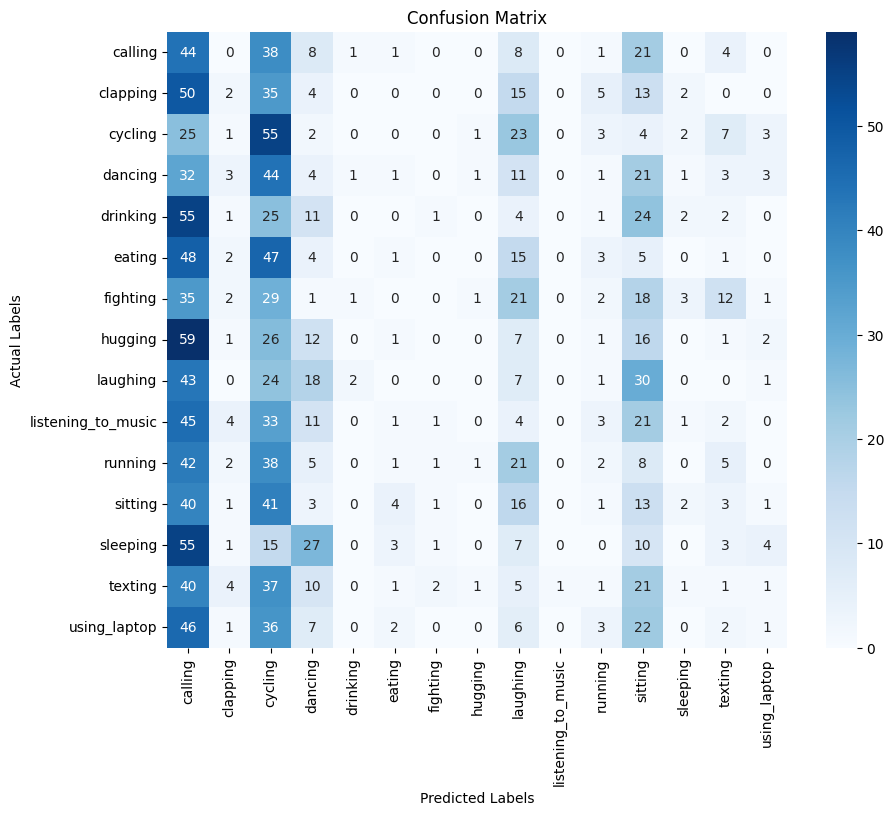

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that your test_df has the actual labels in a column named 'label'
true_labels = test_df['label']
predicted_labels = test_df['predicted_label']

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(train_generator.class_indices.keys()))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Classification report
print(classification_report(true_labels, predicted_labels))

# Calculate ROC AUC for each class
roc_auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predicted_labels), multi_class='ovo')

print(f'ROC AUC score: {roc_auc}')

# If it's a binary classification, you could plot ROC curve like this:
if len(np.unique(true_labels)) == 2:
    fpr, tpr, thresholds = roc_curve(true_labels, test_predictions_prob[:, 1])  # Assuming positive class is at index 1
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

                    precision    recall  f1-score   support

           calling       0.07      0.35      0.11       126
          clapping       0.08      0.02      0.03       126
           cycling       0.11      0.44      0.17       126
           dancing       0.03      0.03      0.03       126
          drinking       0.00      0.00      0.00       126
            eating       0.06      0.01      0.01       126
          fighting       0.00      0.00      0.00       126
           hugging       0.00      0.00      0.00       126
          laughing       0.04      0.06      0.05       126
listening_to_music       0.00      0.00      0.00       126
           running       0.07      0.02      0.03       126
           sitting       0.05      0.10      0.07       126
          sleeping       0.00      0.00      0.00       126
           texting       0.02      0.01      0.01       126
      using_laptop       0.06      0.01      0.01       126

          accuracy                    

# **Demo**

1/1 [==============================] - 0s 19ms/step


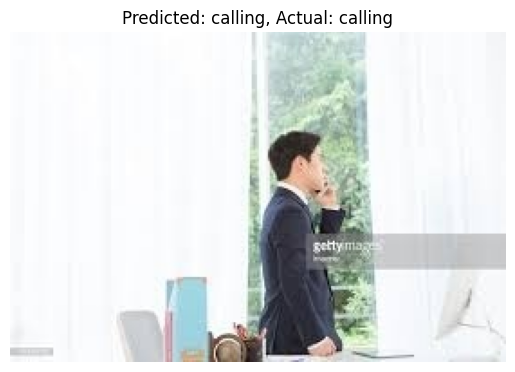

In [23]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(32, 32)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to make a prediction on a single image
def predict_single_image(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return class_labels[predicted_class]

# Assuming 'test_df' is your DataFrame containing the test images and labels
# Make sure 'test_df' has a column 'filename' with the image filenames
# and 'label' with the true labels

# Randomly pick an image from the test set
random_index = random.choice(test_df.index)
random_image_name = test_df.loc[random_index, 'filename']
random_image_path = os.path.join(train_path, random_image_name)  # Adjust if your test images are in a different folder
true_label = test_df.loc[random_index, 'label']

# Load and preprocess the image
img_array = load_and_preprocess_image(random_image_path)

# Predict the class for the image
predicted_label = predict_single_image(vgg_model, img_array, class_labels=list(train_generator.class_indices.keys()))

# Plot the image and the prediction
plt.imshow(image.load_img(random_image_path))
plt.title(f'Predicted: {predicted_label}, Actual: {true_label}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 18ms/step


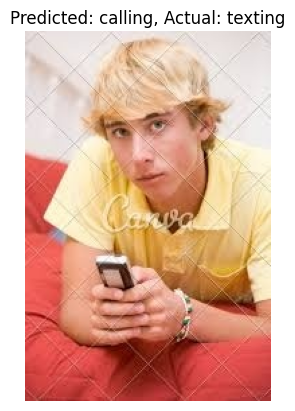

In [25]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(32, 32)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to make a prediction on a single image
def predict_single_image(model, img_array, class_labels):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    return class_labels[predicted_class]

# Assuming 'test_df' is your DataFrame containing the test images and labels
# Make sure 'test_df' has a column 'filename' with the image filenames
# and 'label' with the true labels

# Randomly pick an image from the test set
random_index = random.choice(test_df.index)
random_image_name = test_df.loc[random_index, 'filename']
random_image_path = os.path.join(train_path, random_image_name)  # Adjust if your test images are in a different folder
true_label = test_df.loc[random_index, 'label']

# Load and preprocess the image
img_array = load_and_preprocess_image(random_image_path)

# Predict the class for the image
predicted_label = predict_single_image(vgg_model, img_array, class_labels=list(train_generator.class_indices.keys()))

# Plot the image and the prediction
plt.imshow(image.load_img(random_image_path))
plt.title(f'Predicted: {predicted_label}, Actual: {true_label}')
plt.axis('off')
plt.show()

### As we can see because of low accuracy of model performance, the model gives correct classification for some images and misclassifies some images as shown above.

### **It appears that a larger and more varied data set, coupled with an advanced modelling approach may be needed for better model performance. These aspects will be the focus for future improvements.**